In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import theano.tensor as tt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


## Problem Type

IC<sub>50</sub> determination is a commonplace problem type for experimental biochemists. The goal is to determine the concentration of an inhibitor that causes a protein to have 1/2 as much activity as without the inhibitor.

Classically, this is done by fitting a logistic function of some sort, where the IC<sub>50</sub> is a parameter in the model. We then want to determine IC<sub>50</sub>, given the data at hand.

In the implementation here, we allow for multi-drug IC<sub>50</sub> determination. Additionally, I also show how we can have a mix of noisy data and have non-uniform coverage over the drug concentration space, and still come to a fairly precise determination of the IC<sub>50</sub> values as long as we have dense enough data around the true IC50 area. The simulated data below assumes that a first-pass experiment was done over a wide range of data points, followed by a second-pass set of experiments where a range of concentrations was filled in with more resolution.

## Data structure

To use it with this model, the data should be structured as such:

- Each row is one measurement for one concentration of drug.
- The columns should indicate, at the minimum:
    - What treatment group the sample belonged to.
    - The measured value.

## Extensions to the model

None

## Reporting summarized findings

Here are examples of how to summarize the findings.

> The IC<sub>50</sub> of drug X was `mean` (95% HPD: [`lower`, `upper`]).

## Other notes

None

In [2]:
# Generate some fake data.
x_concs = np.concatenate([np.arange(0, 100, 10), np.arange(5, 21, 1), np.arange(40, 51, 1), np.arange(85, 96, 1)]).reshape(-1, 1)
log_xconcs = np.log(x_concs)
ic50_true = np.array([42, 13, 88])
ic50_true = ic50_true.reshape(-1, ic50_true.shape[0])
beta_true = 1
slope_true = 1
intercept_true = 150
# y_true = slope_true * x_concs + intercept_true

y_true = beta_true / (1 + np.exp(x_concs - ic50_true))

y_noisy = y_true + np.random.normal(0, 0.15, size=y_true.shape)  # homoskedastic error
y_noisy[0:5]

array([[ 0.86164503,  1.08661957,  0.72868388],
       [ 0.7341392 ,  0.78495707,  1.31257221],
       [ 0.75948009,  0.00276828,  1.01595038],
       [ 1.07456009,  0.24971735,  0.94949296],
       [ 0.73539286, -0.26005472,  1.17882456]])

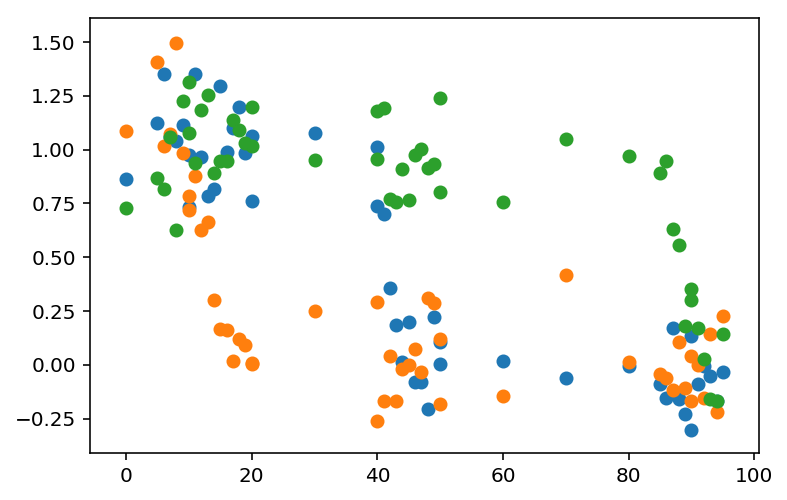

In [3]:
plt.scatter(x_concs, y_noisy[:, 0])
plt.scatter(x_concs, y_noisy[:, 1])
plt.scatter(x_concs, y_noisy[:, 2])

Note how there's sparse coverage in the regions outside of the true IC<sub>50</sub>s.

In [4]:
concentrations = np.concatenate([x_concs] * ic50_true.shape[1])
concentrations[::10]  # print every 10th 

array([[ 0],
       [ 5],
       [15],
       [44],
       [88],
       [20],
       [ 7],
       [17],
       [46],
       [90],
       [40],
       [ 9],
       [19],
       [48],
       [92]])

In [5]:
concentrations.shape

(144, 1)

In [6]:
y_noisy.flatten(order='F').shape

(144,)

In [7]:
x_concs.shape[0]

48

In [8]:
data = pd.DataFrame()
data['concentrations'] = concentrations.reshape(concentrations.shape[0],)
data['measurements'] = y_noisy.flatten(order='F')

drugs = []
for i in range(ic50_true.shape[1]):
    drugs.extend([i] * x_concs.shape[0])
data['drug'] = drugs

data = pm.floatX(data)


from sklearn.preprocessing import LabelEncoder, MinMaxScaler

le = LabelEncoder()
data['idxs'] = le.fit_transform(data['drug']).astype('int32')

# Normalize data['measurements'] to 0-1
# mms = MinMaxScaler()
# data['measurements'] = mms.fit_transform(data['measurements'].values.reshape(-1, 1))

In [9]:
data.head().dtypes

concentrations    float32
measurements      float32
drug              float32
idxs                int32
dtype: object

In [13]:
with pm.Model() as model:
    datasize = len(set(data['idxs']))
    beta = pm.Normal('beta', mu=0, sd=100**2, shape=datasize)
    noise = pm.HalfCauchy('noise', beta=100**2, shape=datasize)
    ic50 = pm.Normal('IC50', sd=100**2, shape=datasize)
    measurements = pm.Deterministic('measurements', 
                                    beta[data['idxs'].values] / (1 + tt.exp(data['concentrations'].values - ic50[data['idxs'].values])))

    
    y_like = pm.Normal('y_like', mu=measurements, sd=noise[data['idxs'].values], observed=data['measurements'])

In [14]:
with model:
    trace = pm.sample(draws=10000, step=pm.Metropolis(), start=pm.find_MAP())  
    # trace = pm.sample(draws=2000)  # ADVI init is fast, but NUTS sampling is slow later on.

ValueError: ('The following error happened while compiling the node', GpuElemwise{Composite{Switch(Identity(GT(i0, i1)), (i2 * ((-(Composite{inv(sqr(i0))}(i0) * i3)) + log((i4 * Composite{inv(sqr(i0))}(i0))))), i5)}}[(0, 0)]<gpuarray>(GpuAdvancedSubtensor1.0, GpuArrayConstant{[0]}, GpuArrayConstant{[ 0.5]}, GpuElemwise{Composite{sqr((i0 - (scalar_sigmoid((-(i1 - i2))) * i3)))}}[(0, 2)]<gpuarray>.0, GpuArrayConstant{[ 0.15915494]}, GpuArrayConstant{[-inf]}), '\n', 'Cannot compute test value: input 0 (<float32>) of Op Composite{inv(sqr(i0))}(<float32>) missing default value. ')

In [ ]:
pm.traceplot(trace[5000:])

Note the posterior distributions around the IC50s are fairly nice and tight.

In [ ]:
pm.summary(trace[5000:])